# Задача 9. Эксперименты: Статика vs. Динамика

В данном исследовании сравнивается производительность трёх алгоритмов, решающих задачу single source shortest path:

    1. Матричная реализация алгоритма Беллмана-Форда.
    2. Классический алгоритм Дейкстры.
    3. Динамический алгоритм, идейно подобный алгоритму Дейкстры.

#### Цель работы:
Исследовать поведение алгоритмов на множестве графов, при изменениях ребер: добавление, удаление.

In [1]:
%%capture
%pip install -r requirements.txt

%pip install matplotlib
%pip install seaborn

import pandas as pd 
import networkx as nx
import itertools
import time
from project.task9 import dijkstra, DynamicSSSP 
from project.pathes import sssp, sssp2

import pygraphblas as pgb
import csv
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import io
import PIL


## Тестовый стенд

In [4]:


! printf '\n========== CPU ==========\n'
! lscpu | grep -E 'Architecture|Model name|Thread\(s\)|Core\(s\)|MHz'

! printf '\n========== RAM ==========\n'
! free -m




========== CPU ==========
Architecture:                    x86_64
Model name:                      AMD Ryzen 5 4500U with Radeon Graphics
Thread(s) per core:              1
Core(s) per socket:              6
CPU max MHz:                     2375,0000
CPU min MHz:                     1400,0000

========== RAM ==========
               total        used        free      shared  buff/cache   available
Mem:           15362       10493        1198         141        3671        4405
Swap:           2047           3        2044


## Генерация графов

Для экспериментов рассматриваются 7 групп графов, в каждой группе по три графа. Деление на группы осуществлялось по количеству вершин: до 100, 1000, 5000, 10000, 25000, 50000, 100000.

Первая группа содержит социальные графы из `nx.generators.social`, поскольку число вершин в них <= 100. Остальные графы были сгенерированы с помошью `nx.generators.community.random_partition_grap`, поскольку данный генератор наиболее дружелюбен для пользователя. Все сгенерированные графы имеют большее число ребер внутри сообществ, чем между ними, также при увеличении числа вершин увеличивалось и число ребер.

In [2]:
def genGraphGroup(size) -> list:
    return [
        nx.generators.community.random_partition_graph([size // 1000] * 1000, 1000 / size    , 1000 / size / 400    , directed=True),
        nx.generators.community.random_partition_graph([size // 100] * 100  , 1000 / size / 2, 1000 / size / 400 / 2, directed=True),
        nx.generators.community.random_partition_graph([size // 25] * 25    , 1000 / size / 8, 1000 / size / 400 / 8, directed=True)

    ]


Graphs = {
    100: [
        nx.DiGraph(nx.generators.social.les_miserables_graph()),
        nx.DiGraph(nx.generators.social.davis_southern_women_graph()),
        nx.DiGraph(nx.generators.social.karate_club_graph()),
    ],
    1000: genGraphGroup(1000),
    5000: genGraphGroup(5000),
    10_000: genGraphGroup(10_000),
    25_000: genGraphGroup(25_000),
    50_000: genGraphGroup(50_000),
    100_000: genGraphGroup(100_000)
}
    

for g in itertools.chain(*Graphs.values()):
    print(g)




DiGraph with 77 nodes and 508 edges
DiGraph with 32 nodes and 178 edges
DiGraph named "Zachary's Karate Club" with 34 nodes and 156 edges
DiGraph named 'stochastic_block_model' with 1000 nodes and 2565 edges
DiGraph named 'stochastic_block_model' with 1000 nodes and 5638 edges
DiGraph named 'stochastic_block_model' with 1000 nodes and 5230 edges
DiGraph named 'stochastic_block_model' with 5000 nodes and 16648 edges
DiGraph named 'stochastic_block_model' with 5000 nodes and 30377 edges
DiGraph named 'stochastic_block_model' with 5000 nodes and 26277 edges
DiGraph named 'stochastic_block_model' with 10000 nodes and 33878 edges
DiGraph named 'stochastic_block_model' with 10000 nodes and 61852 edges
DiGraph named 'stochastic_block_model' with 10000 nodes and 52910 edges
DiGraph named 'stochastic_block_model' with 25000 nodes and 86190 edges
DiGraph named 'stochastic_block_model' with 25000 nodes and 155306 edges
DiGraph named 'stochastic_block_model' with 25000 nodes and 132446 edges
DiGra

## Ход работы

In [3]:
def run_static_dijkstra(graph: nx.DiGraph, type='Inc', to_add=[], to_rm=[]):
    if type == 'Inc':
        g = nx.DiGraph()
        g.add_nodes_from(graph.nodes)
        start_vertex = list(g)[0]

        for e in to_add:
            g.add_edge(*e)

        start = time.time()
        dijkstra(g, start_vertex)
        end = time.time()
    
        return end - start
        
    if type == 'Dec':
        g = nx.DiGraph(graph)
        start_vertex = list(g)[0]
        
        for e in to_rm:
            g.remove_edge(*e)

        start = time.time()
        dijkstra(g, start_vertex)
        end = time.time()

        return end - start

    if type == 'Mix':
        g = nx.DiGraph(graph)
        start_vertex = list(g)[0]
        
        for e_add, e_del in itertools.zip_longest(to_add, to_rm):
            if e_add:
                g.add_edge(*e_add)
            if e_del:
                g.remove_edge(*e_del)

        start = time.time()
        dijkstra(g, start_vertex)
        end = time.time()

        return end - start

    
    
def run_bellman_ford(graph: nx.DiGraph, type='Inc', to_add=[], to_rm=[]):
    if type == 'Inc':
        graph_mat = pgb.Matrix.from_scipy_sparse(nx.to_scipy_sparse_array(graph).astype(float, copy=False))
        graph_mat.eadd(pgb.Matrix.identity(pgb.FP64, graph_mat.nrows, value=0), out=graph_mat)
        

        sssp(graph_mat, 0)


        start = time.time()
        sssp(graph_mat, 0)
        end = time.time()
    
        return end - start
        
    if type == 'Dec':
        graph_upd = nx.DiGraph(graph)
    
        for e in to_rm:
            graph_upd.remove_edge(*e)

        adj_matrix = pgb.Matrix.from_scipy_sparse(nx.to_scipy_sparse_array(graph_upd).astype(float, copy=False))            
        adj_matrix.eadd(pgb.Matrix.identity(pgb.FP64, adj_matrix.nrows, value=0), out=adj_matrix)
        

        start = time.time()
        sssp(adj_matrix, 0)
        end = time.time()
        
        return end - start

    if type == 'Mix':
        graph_upd = nx.DiGraph(graph)

        for e_add, e_del in itertools.zip_longest(to_add, to_rm):
            if e_add:
                graph_upd.add_edge(*e_add)
            if e_del:
                graph_upd.remove_edge(*e_del)
                
        adj_matrix = pgb.Matrix.from_scipy_sparse(nx.to_scipy_sparse_array(graph_upd).astype(float, copy=False))            
        adj_matrix.eadd(pgb.Matrix.identity(pgb.FP64, adj_matrix.nrows, value=0), out=adj_matrix)

    
        start = time.time()
        sssp(adj_matrix, 0)
        end = time.time()
        
        return end - start
    
    
def run_dynamic_dijkstra(graph: nx.DiGraph, type='Inc', to_add=[], to_rm=[]):
    if type == 'Inc':
        graph_upd = nx.DiGraph()
        graph_upd.add_nodes_from(graph.nodes)
        
        start_vertex = list(graph_upd)[0]
        dynamic_sssp = DynamicSSSP(graph_upd, start_vertex)
        
        for e in to_add:
            dynamic_sssp.add_edge(*e)

        start = time.time()
        dynamic_sssp.get_distances()
        end = time.time()

        return end - start
    
    if type == 'Dec':
        graph_upd = nx.DiGraph(graph)
        start_vertex = list(graph_upd)[0]
        dynamic_sssp = DynamicSSSP(graph_upd, start_vertex)
        
        for e in to_rm:
            dynamic_sssp.remove_edge(*e)

        start = time.time()
        dynamic_sssp.get_distances()
        end = time.time()

        return end - start

    if type == 'Mix':
        graph_upd = nx.DiGraph(graph)

        start_vertex = list(graph_upd)[0]
        dynamic_sssp = DynamicSSSP(graph_upd, start_vertex)

        for e_add, e_del in itertools.zip_longest(to_add, to_rm):
            if e_add:
                dynamic_sssp.add_edge(*e_add)
            if e_del:
                dynamic_sssp.remove_edge(*e_del)

        start = time.time()
        dynamic_sssp.get_distances()
        end = time.time()

        return end - start

In [4]:
def select_edges(g: nx.DiGraph, edges_part: float):
    n = int(g.number_of_edges() * edges_part)
    return random.sample(list(g.edges), k=n)

def go (partitions, output):
    with open(output + '.csv', 'w',) as csvfile:
        writer = csv.writer(csvfile)

        for mod in [
            'Inc', 
            'Dec', 
            'Mix'
        ]:
            for p in partitions:
                for nodes_num, graph_list in Graphs.items():
                    for g in graph_list:
                        add_edges=[]
                        rm_edges=[]
                        if mod == 'Inc':
                            add_edges = select_edges(g, p)
                        if mod == 'Dec':
                            rm_edges = select_edges(g, p)
                        if mod == 'Mix':
                            edges = select_edges(g, p)
                            add_edges_num = len(edges) // 2
                            del_edges_num = len(edges) - add_edges_num

                            add_edges = random.sample(edges, k=add_edges_num)
                            g = nx.DiGraph(g)
                            g.remove_edges_from(add_edges)
                            rm_edges = random.sample(list(g.edges), k=del_edges_num)

                        t = run_bellman_ford(nx.DiGraph(g), mod, add_edges, rm_edges)
                        writer.writerow((mod, p, 'matrix', nodes_num, t))

                        t = run_dynamic_dijkstra(nx.DiGraph(g), mod, add_edges, rm_edges)
                        writer.writerow((mod, p, 'dynamic', nodes_num, t))

                        t = run_static_dijkstra(nx.DiGraph(g), mod, add_edges, rm_edges)
                        writer.writerow((mod, p, 'dijkstra', nodes_num, t))



In [8]:
go([0.1, 0.2, 0.3, 0.4, 0.5], "results")

In [9]:
df = pd.read_csv('results.csv', names=['mod', 'modified_edges_part', 'algorithm', 'nodes', 'time(s)'])
df

mod  modified_edges_part algorithm   nodes     time(s)
0    Inc                  0.1    matrix     100    0.000928
1    Inc                  0.1   dynamic     100    0.000133
2    Inc                  0.1  dijkstra     100    0.000022
3    Inc                  0.1    matrix     100    0.000400
4    Inc                  0.1   dynamic     100    0.000061
..   ...                  ...       ...     ...         ...
940  Mix                  0.5   dynamic  100000    5.619338
941  Mix                  0.5  dijkstra  100000    1.288174
942  Mix                  0.5    matrix  100000  182.495705
943  Mix                  0.5   dynamic  100000    5.356790
944  Mix                  0.5  dijkstra  100000    1.140982

[945 rows x 5 columns]

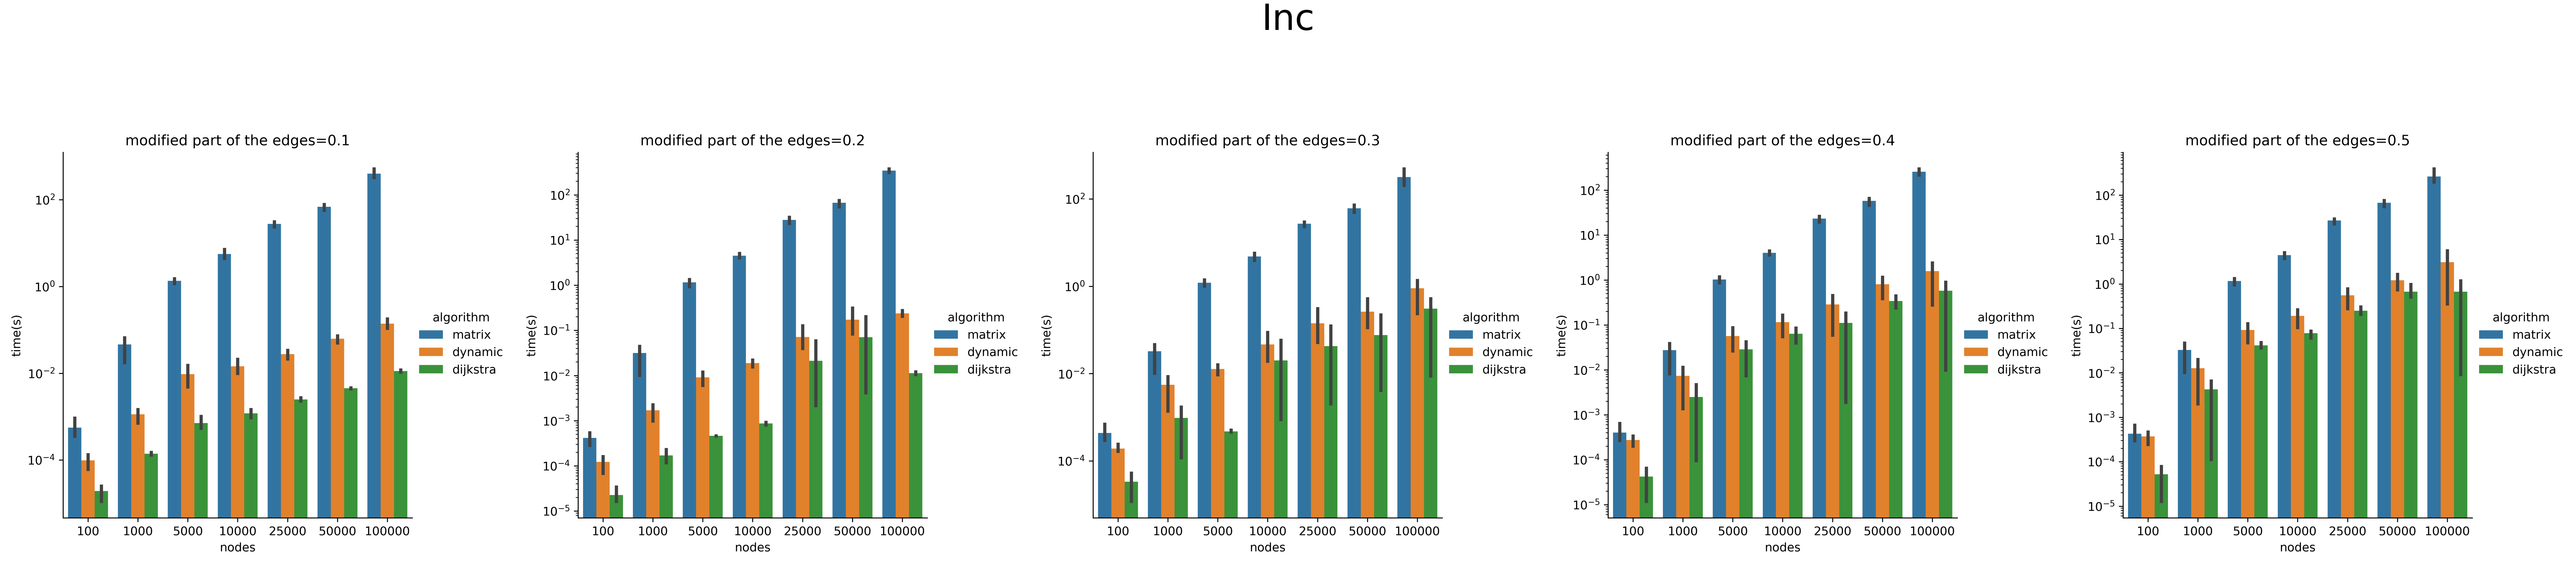

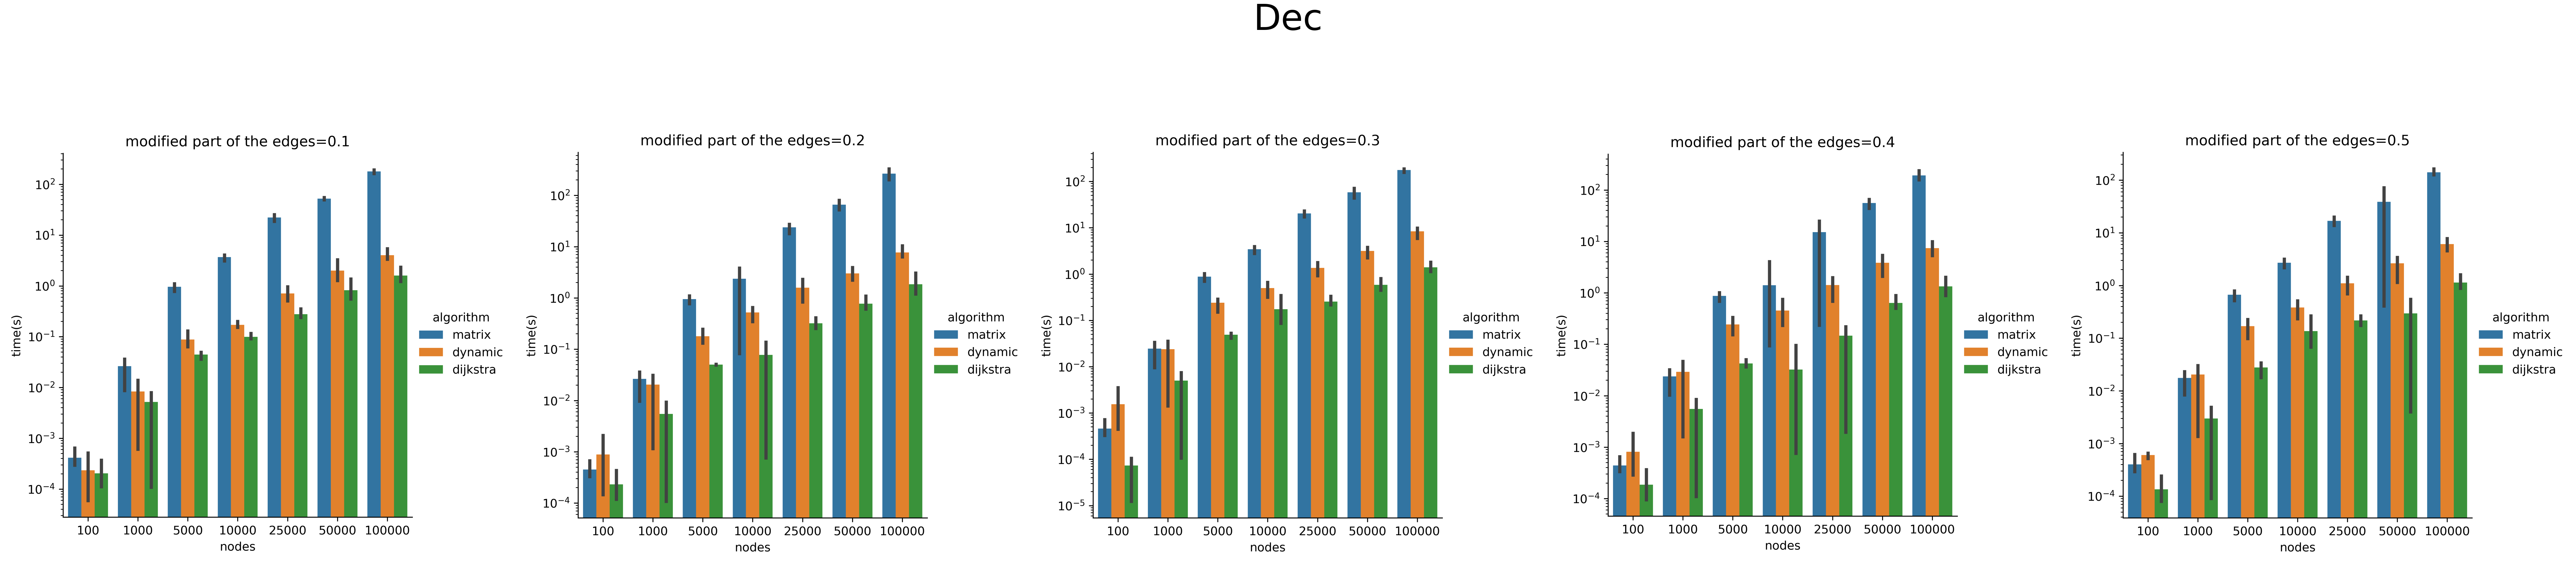

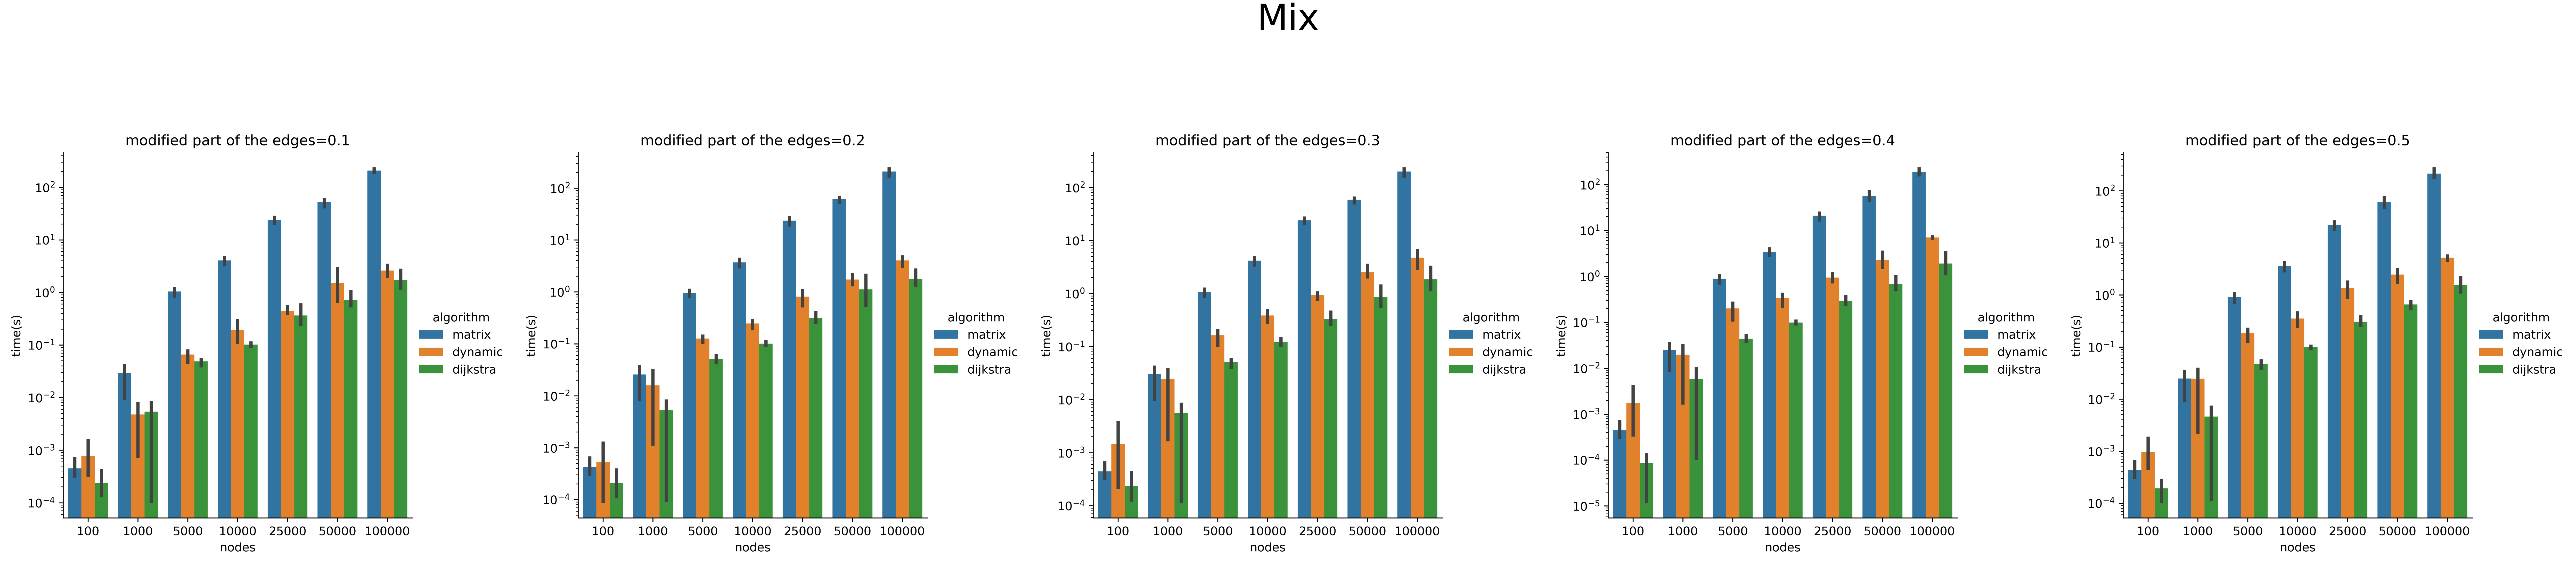

In [10]:
def to_image(plot):
    buffer = io.BytesIO()
    plot.figure.savefig(buffer, format="png", bbox_inches="tight", dpi=450)
    return PIL.Image.open(buffer)


for mod in [
    'Inc', 
    'Dec', 
    'Mix'
]:
    plots = []
    for p in [0.1, 0.2, 0.3, 0.4, 0.5]:
        filtered_df = df[
            np.logical_and(df['mod'] == mod, df['modified_edges_part'] == p)
        ]
        plot = sns.catplot(
            data=filtered_df, 
            x="nodes",
            y="time(s)",
            hue="algorithm",
            kind='bar', 
        )
        plt.title(f"modified part of the edges={p}")
        plt.yscale("log")
        plots.append(to_image(plot))
        plt.close()
    
    fig, axs = plt.subplots(ncols=5, figsize=(100, 50))
    for ax, plot in zip(axs, plots):
        ax.imshow(plot)
        ax.axis("off")
    fig.set_tight_layout(True)
    fig.suptitle(f"{mod}", y=0.75, size=100)

## Вывод 1

1. Матричный алгоритм Белмана-Форда имеет наихудшую производительность во всех случаях, 
   кроме декрементальных изменениях графов до 1000 вершин, при удалении >= 20% ребер
   и при смешанных изменениях графов до 100 вершин.
2. При инкрементальных изменениях динамический алгоритм работает быстрее чем на декрементальных и смешанных
3. Наилучший результат показал статический алгоритм Белмана-Форда

Стремительное увеличение времени работы статического алгоритма можно объяснить тем, 
что графы генерировались так, что с увеличением числа вершин увеличивалось и число ребер,
следовательно матрицы смежности имеют большее число ненулевых элементов при увеличении числа вершин. 
##### Также в реализации матричного алгоритма отсутствует сравнение с последним результатом умножения, поэтому алгоритм всегда выполнял все матричные умножения. 

Преимущество статического алгоритма перед динамическим в этой работе можно объяснить тем, 
что изменения ребер происходят случайным образом.

### Добавим сравнение с последним результатом умножения в матричном алгоритме и проведем сравнение еще раз:

In [5]:
def run_bellman_ford2(graph: nx.DiGraph, type='Inc', to_add=[], to_rm=[]):
    if type == 'Inc':
        graph_mat = pgb.Matrix.from_scipy_sparse(nx.to_scipy_sparse_array(graph).astype(float, copy=False))
        graph_mat.eadd(pgb.Matrix.identity(pgb.FP64, graph_mat.nrows, value=0), out=graph_mat)
        

        sssp2(graph_mat, 0)


        start = time.time()
        sssp2(graph_mat, 0)
        end = time.time()
    
        return end - start
        
    if type == 'Dec':
        graph_upd = nx.DiGraph(graph)
    
        for e in to_rm:
            graph_upd.remove_edge(*e)

        adj_matrix = pgb.Matrix.from_scipy_sparse(nx.to_scipy_sparse_array(graph_upd).astype(float, copy=False))            
        adj_matrix.eadd(pgb.Matrix.identity(pgb.FP64, adj_matrix.nrows, value=0), out=adj_matrix)
        

        start = time.time()
        sssp2(adj_matrix, 0)
        end = time.time()
        
        return end - start

    if type == 'Mix':
        graph_upd = nx.DiGraph(graph)

        for e_add, e_del in itertools.zip_longest(to_add, to_rm):
            if e_add:
                graph_upd.add_edge(*e_add)
            if e_del:
                graph_upd.remove_edge(*e_del)
                
        adj_matrix = pgb.Matrix.from_scipy_sparse(nx.to_scipy_sparse_array(graph_upd).astype(float, copy=False))            
        adj_matrix.eadd(pgb.Matrix.identity(pgb.FP64, adj_matrix.nrows, value=0), out=adj_matrix)

    
        start = time.time()
        sssp2(adj_matrix, 0)
        end = time.time()
        
        return end - start
    


In [6]:
with open("results2" + '.csv', 'w',) as csvfile:
        writer = csv.writer(csvfile)

        for mod in [
            'Inc', 
            'Dec', 
            'Mix'
        ]:
            for p in [0.1, 0.2, 0.3, 0.4, 0.5]:
                for nodes_num, graph_list in Graphs.items():
                    for g in graph_list:
                        add_edges=[]
                        rm_edges=[]
                        if mod == 'Inc':
                            add_edges = select_edges(g, p)
                        if mod == 'Dec':
                            rm_edges = select_edges(g, p)
                        if mod == 'Mix':
                            edges = select_edges(g, p)
                            add_edges_num = len(edges) // 2
                            del_edges_num = len(edges) - add_edges_num

                            add_edges = random.sample(edges, k=add_edges_num)
                            g = nx.DiGraph(g)
                            g.remove_edges_from(add_edges)
                            rm_edges = random.sample(list(g.edges), k=del_edges_num)

                        t = run_bellman_ford2(nx.DiGraph(g), mod, add_edges, rm_edges)
                        writer.writerow((mod, p, 'matrix2', nodes_num, t))
                        print(mod, p, 'matrix2', nodes_num, t)

                            
                        t = run_dynamic_dijkstra(nx.DiGraph(g), mod, add_edges, rm_edges)
                        writer.writerow((mod, p, 'dynamic', nodes_num, t))
                        print(mod, p, 'dynamic', nodes_num, t)
                        
                        t = run_static_dijkstra(nx.DiGraph(g), mod, add_edges, rm_edges)
                        writer.writerow((mod, p, 'dijkstra', nodes_num, t))
                        print(mod, p, 'dijkstra', nodes_num, t)



Inc 0.1 matrix2 100 0.00037360191345214844
Inc 0.1 dynamic 100 8.606910705566406e-05
Inc 0.1 dijkstra 100 1.1444091796875e-05
Inc 0.1 matrix2 100 0.0001914501190185547
Inc 0.1 dynamic 100 5.078315734863281e-05
Inc 0.1 dijkstra 100 1.33514404296875e-05
Inc 0.1 matrix2 100 0.0001952648162841797
Inc 0.1 dynamic 100 4.124641418457031e-05
Inc 0.1 dijkstra 100 1.2636184692382812e-05
Inc 0.1 matrix2 1000 0.002887248992919922
Inc 0.1 dynamic 1000 0.00043082237243652344
Inc 0.1 dijkstra 1000 8.7738037109375e-05
Inc 0.1 matrix2 1000 0.002808094024658203
Inc 0.1 dynamic 1000 0.0008742809295654297
Inc 0.1 dijkstra 1000 8.463859558105469e-05
Inc 0.1 matrix2 1000 0.002968311309814453
Inc 0.1 dynamic 1000 0.0008242130279541016
Inc 0.1 dijkstra 1000 9.560585021972656e-05
Inc 0.1 matrix2 5000 0.013983011245727539
Inc 0.1 dynamic 5000 0.002621173858642578
Inc 0.1 dijkstra 5000 0.0003681182861328125
Inc 0.1 matrix2 5000 0.013741016387939453
Inc 0.1 dynamic 5000 0.005115032196044922
Inc 0.1 dijkstra 5000 

Inc 0.4 matrix2 5000 0.015020132064819336
Inc 0.4 dynamic 5000 0.026922225952148438
Inc 0.4 dijkstra 5000 0.013225555419921875
Inc 0.4 matrix2 5000 0.014805078506469727
Inc 0.4 dynamic 5000 0.01526021957397461
Inc 0.4 dijkstra 5000 0.00035953521728515625
Inc 0.4 matrix2 5000 0.01462697982788086
Inc 0.4 dynamic 5000 0.05961418151855469
Inc 0.4 dijkstra 5000 0.032082319259643555
Inc 0.4 matrix2 10000 0.02934575080871582
Inc 0.4 dynamic 10000 0.021808862686157227
Inc 0.4 dijkstra 10000 0.0008051395416259766
Inc 0.4 matrix2 10000 0.02866196632385254
Inc 0.4 dynamic 10000 0.16742229461669922
Inc 0.4 dijkstra 10000 0.07036852836608887
Inc 0.4 matrix2 10000 0.0287020206451416
Inc 0.4 dynamic 10000 0.028571128845214844
Inc 0.4 dijkstra 10000 0.0007078647613525391
Inc 0.4 matrix2 25000 0.07207417488098145
Inc 0.4 dynamic 25000 0.16588973999023438
Inc 0.4 dijkstra 25000 0.12052488327026367
Inc 0.4 matrix2 25000 0.0715322494506836
Inc 0.4 dynamic 25000 0.4674665927886963
Inc 0.4 dijkstra 25000 0.

Dec 0.2 matrix2 5000 0.015090703964233398
Dec 0.2 dynamic 5000 0.18212103843688965
Dec 0.2 dijkstra 5000 0.04220414161682129
Dec 0.2 matrix2 10000 0.03332638740539551
Dec 0.2 dynamic 10000 0.27426958084106445
Dec 0.2 dijkstra 10000 0.13720130920410156
Dec 0.2 matrix2 10000 0.028980016708374023
Dec 0.2 dynamic 10000 0.3559236526489258
Dec 0.2 dijkstra 10000 0.10234236717224121
Dec 0.2 matrix2 10000 0.02901005744934082
Dec 0.2 dynamic 10000 0.47220635414123535
Dec 0.2 dijkstra 10000 0.0833890438079834
Dec 0.2 matrix2 25000 0.07309746742248535
Dec 0.2 dynamic 25000 0.8837997913360596
Dec 0.2 dijkstra 25000 0.49656200408935547
Dec 0.2 matrix2 25000 0.06966495513916016
Dec 0.2 dynamic 25000 2.3154098987579346
Dec 0.2 dijkstra 25000 0.231475830078125
Dec 0.2 matrix2 25000 0.07234358787536621
Dec 0.2 dynamic 25000 1.4650895595550537
Dec 0.2 dijkstra 25000 0.2395339012145996
Dec 0.2 matrix2 50000 0.14461493492126465
Dec 0.2 dynamic 50000 2.253877639770508
Dec 0.2 dijkstra 50000 1.0135681629180

Dec 0.5 dynamic 10000 0.4583909511566162
Dec 0.5 dijkstra 10000 0.07223653793334961
Dec 0.5 matrix2 10000 0.027760028839111328
Dec 0.5 dynamic 10000 0.4096353054046631
Dec 0.5 dijkstra 10000 0.06633281707763672
Dec 0.5 matrix2 25000 0.07945799827575684
Dec 0.5 dynamic 25000 0.6929068565368652
Dec 0.5 dijkstra 25000 0.27117061614990234
Dec 0.5 matrix2 25000 0.07304644584655762
Dec 0.5 dynamic 25000 1.410524606704712
Dec 0.5 dijkstra 25000 0.19762206077575684
Dec 0.5 matrix2 25000 0.07367181777954102
Dec 0.5 dynamic 25000 1.143378734588623
Dec 0.5 dijkstra 25000 0.1667330265045166
Dec 0.5 matrix2 50000 0.1585698127746582
Dec 0.5 dynamic 50000 1.4860656261444092
Dec 0.5 dijkstra 50000 0.40254878997802734
Dec 0.5 matrix2 50000 0.14286088943481445
Dec 0.5 dynamic 50000 3.0477139949798584
Dec 0.5 dijkstra 50000 1.0872740745544434
Dec 0.5 matrix2 50000 0.13835883140563965
Dec 0.5 dynamic 50000 2.4956512451171875
Dec 0.5 dijkstra 50000 0.34904050827026367
Dec 0.5 matrix2 100000 0.3013684749603

Mix 0.3 dynamic 25000 1.6533660888671875
Mix 0.3 dijkstra 25000 0.4938516616821289
Mix 0.3 matrix2 25000 0.07154417037963867
Mix 0.3 dynamic 25000 1.0021703243255615
Mix 0.3 dijkstra 25000 0.2782919406890869
Mix 0.3 matrix2 25000 0.07260727882385254
Mix 0.3 dynamic 25000 0.9056742191314697
Mix 0.3 dijkstra 25000 0.24278712272644043
Mix 0.3 matrix2 50000 0.14681386947631836
Mix 0.3 dynamic 50000 1.4061179161071777
Mix 0.3 dijkstra 50000 0.9261972904205322
Mix 0.3 matrix2 50000 0.14192724227905273
Mix 0.3 dynamic 50000 3.2151012420654297
Mix 0.3 dijkstra 50000 0.6935451030731201
Mix 0.3 matrix2 50000 0.13084721565246582
Mix 0.3 dynamic 50000 2.239109754562378
Mix 0.3 dijkstra 50000 0.4782845973968506
Mix 0.3 matrix2 100000 0.29412341117858887
Mix 0.3 dynamic 100000 2.738377332687378
Mix 0.3 dijkstra 100000 2.9057366847991943
Mix 0.3 matrix2 100000 0.30489063262939453
Mix 0.3 dynamic 100000 6.772790193557739
Mix 0.3 dijkstra 100000 1.2450764179229736
Mix 0.3 matrix2 100000 0.2844843864440

In [9]:
df = pd.read_csv('results2.csv', names=['mod', 'modified_edges_part', 'algorithm', 'nodes', 'time(s)'])
df

mod  modified_edges_part algorithm   nodes   time(s)
0    Inc                  0.1   matrix2     100  0.000374
1    Inc                  0.1   dynamic     100  0.000086
2    Inc                  0.1  dijkstra     100  0.000011
3    Inc                  0.1   matrix2     100  0.000191
4    Inc                  0.1   dynamic     100  0.000051
..   ...                  ...       ...     ...       ...
940  Mix                  0.5   dynamic  100000  5.263814
941  Mix                  0.5  dijkstra  100000  1.065416
942  Mix                  0.5   matrix2  100000  0.279412
943  Mix                  0.5   dynamic  100000  6.225802
944  Mix                  0.5  dijkstra  100000  1.157015

[945 rows x 5 columns]

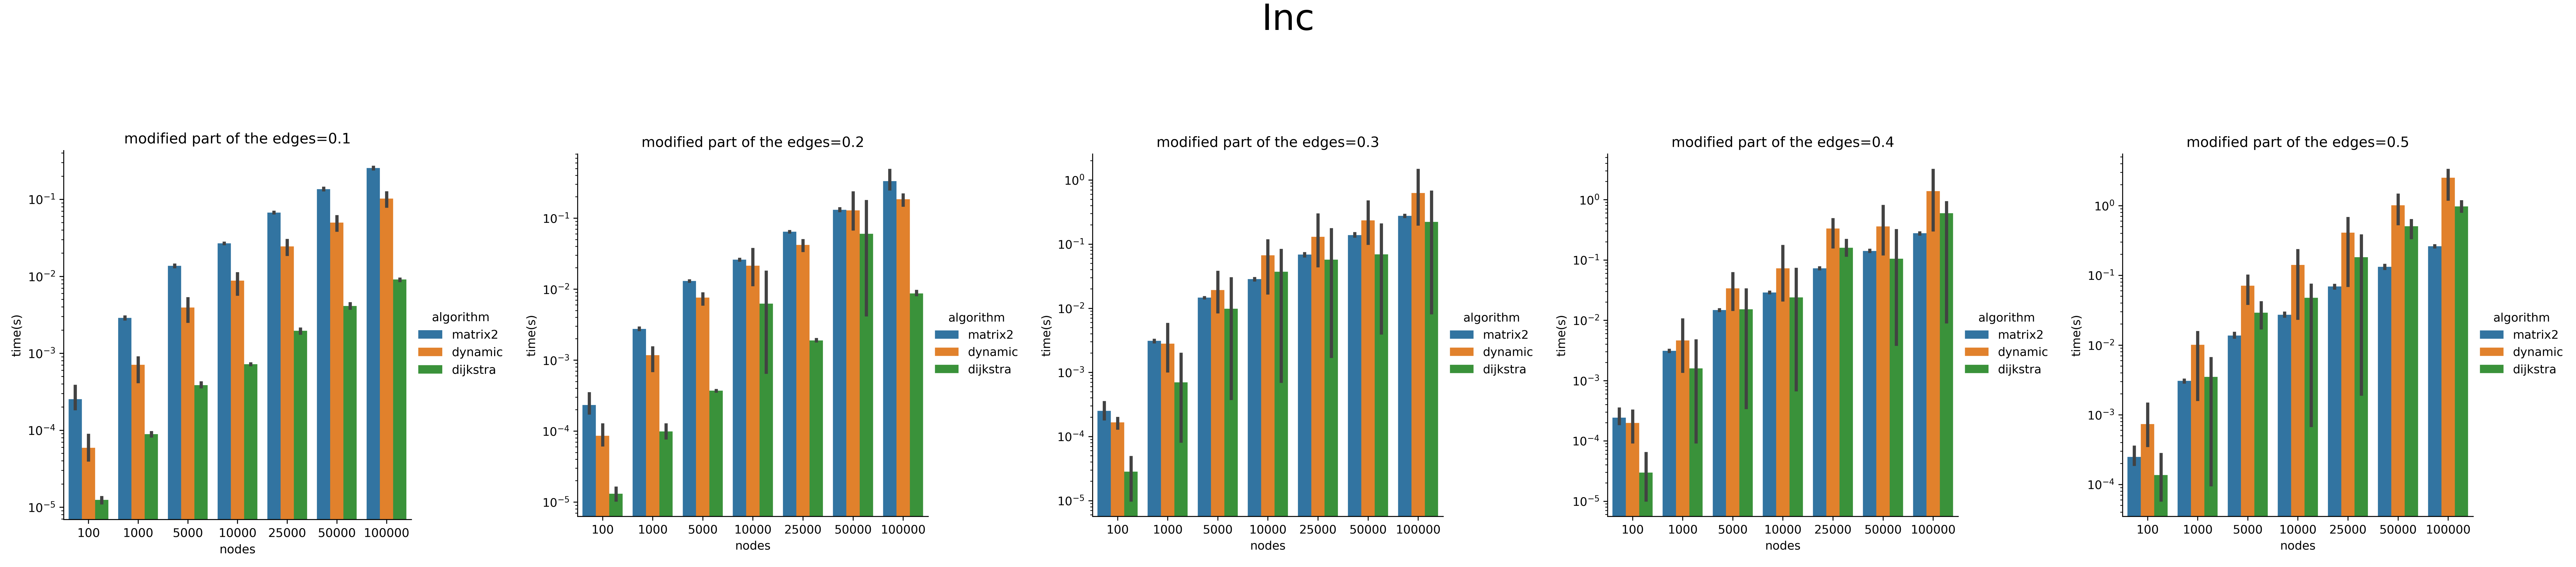

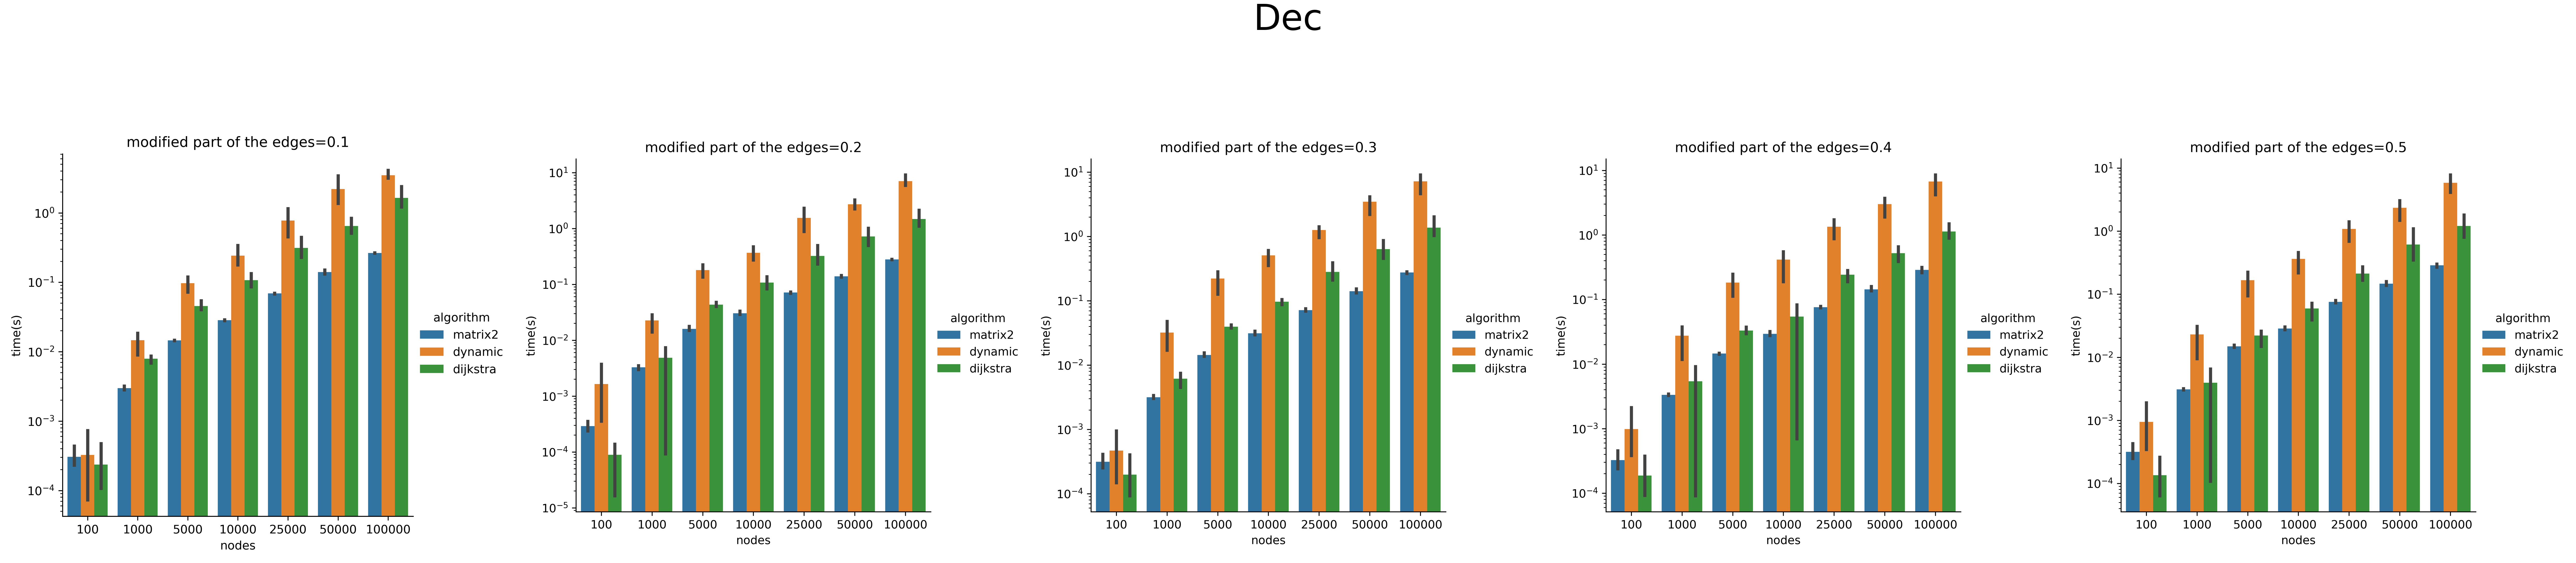

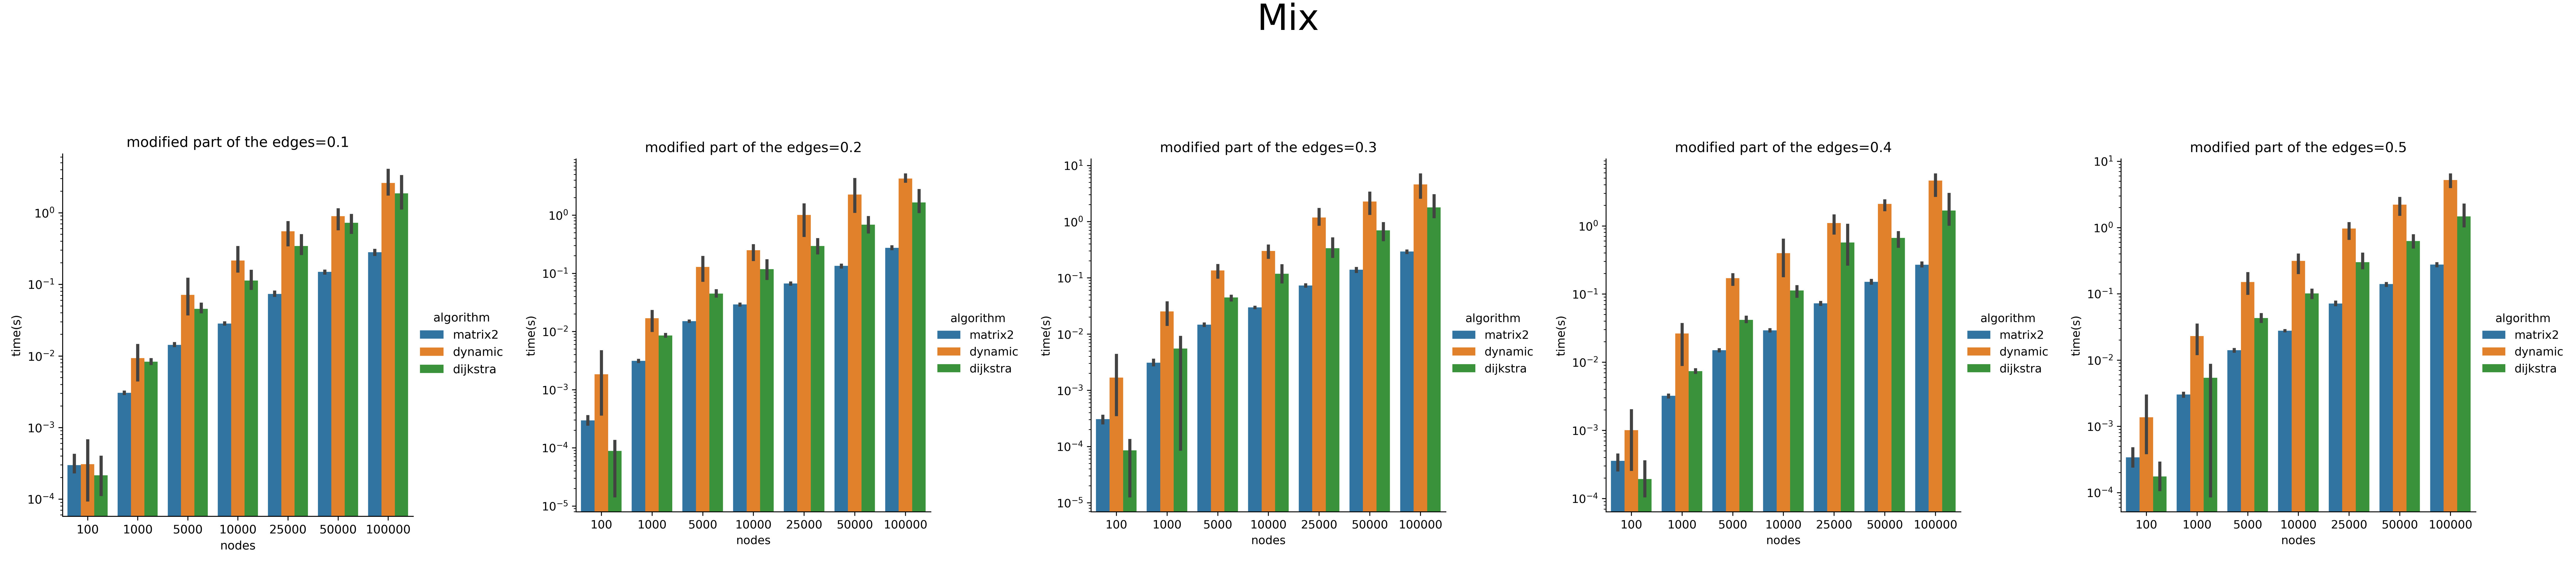

In [10]:
def to_image(plot):
    buffer = io.BytesIO()
    plot.figure.savefig(buffer, format="png", bbox_inches="tight", dpi=450)
    return PIL.Image.open(buffer)


for mod in [
    'Inc', 
    'Dec', 
    'Mix'
]:
    plots = []
    for p in [0.1, 0.2, 0.3, 0.4, 0.5]:
        filtered_df = df[
            np.logical_and(df['mod'] == mod, df['modified_edges_part'] == p)
        ]
        plot = sns.catplot(
            data=filtered_df, 
            x="nodes",
            y="time(s)",
            hue="algorithm",
            kind='bar', 
        )
        plt.title(f"modified part of the edges={p}")
        plt.yscale("log")
        plots.append(to_image(plot))
        plt.close()
    
    fig, axs = plt.subplots(ncols=5, figsize=(100, 50))
    for ax, plot in zip(axs, plots):
        ax.imshow(plot)
        ax.axis("off")
    fig.set_tight_layout(True)
    fig.suptitle(f"{mod}", y=0.75, size=100)

## Выводы 2
    1. Как и ожидалось, матричный алгоритм со сравнением результата последнего умножения превосходит алгоритм без сравнения.
    2. Статический алгоритм Дейкстры теперь не является выраженным фаворитом, матричный алгоритм выигрывает на   немалых графах (> 100 вершин), при декрементальных и смешанных изменениях, однако на малых графах, алгоритм Дейкстры по прежнему имеет преимущество. Также Алгоритм Дейкстры выигрывает, при инкрементальных изменениях до  50% ребер и на малых графах, при инкрементальных изменениях 50% ребер.

Таким образом, на практике, для работы с немалыми графами, при условии наличия необходимости изменения большого количества ребер имеет смысл выбрать матричную реализацию алгоритма Беллмана-Форда.

### Рассмотрим поведение динамического и статических алгоритмов, при меньших долях изменяемых ребер:

In [13]:
with open("results1" + '.csv', 'w',) as csvfile:
        writer = csv.writer(csvfile)

        for mod in [
            'Inc', 
            'Dec', 
            'Mix'
        ]:
            for p in [0.001, 0.005, 0.01]:
                for nodes_num, graph_list in Graphs.items():
                    for g in graph_list:
                        add_edges=[]
                        rm_edges=[]
                        if mod == 'Inc':
                            add_edges = select_edges(g, p)
                        if mod == 'Dec':
                            rm_edges = select_edges(g, p)
                        if mod == 'Mix':
                            edges = select_edges(g, p)
                            add_edges_num = len(edges) // 2
                            del_edges_num = len(edges) - add_edges_num

                            add_edges = random.sample(edges, k=add_edges_num)
                            g = nx.DiGraph(g)
                            g.remove_edges_from(add_edges)
                            rm_edges = random.sample(list(g.edges), k=del_edges_num)

                        t = run_dynamic_dijkstra(nx.DiGraph(g), mod, add_edges, rm_edges)
                        writer.writerow((mod, p, 'dynamic', nodes_num, t))
                        print(mod, p, 'dynamic', nodes_num, t)
                        
                        t = run_static_dijkstra(nx.DiGraph(g), mod, add_edges, rm_edges)
                        writer.writerow((mod, p, 'dijkstra', nodes_num, t))
                        print(mod, p, 'dijkstra', nodes_num, t)



Inc 0.001 dynamic 100 0.0005486011505126953
Inc 0.001 dijkstra 100 1.5735626220703125e-05
Inc 0.001 dynamic 100 6.67572021484375e-06
Inc 0.001 dijkstra 100 7.152557373046875e-06
Inc 0.001 dynamic 100 5.0067901611328125e-06
Inc 0.001 dijkstra 100 6.4373016357421875e-06
Inc 0.001 dynamic 1000 2.9087066650390625e-05
Inc 0.001 dijkstra 1000 8.082389831542969e-05
Inc 0.001 dynamic 1000 3.743171691894531e-05
Inc 0.001 dijkstra 1000 8.344650268554688e-05
Inc 0.001 dynamic 1000 3.528594970703125e-05
Inc 0.001 dijkstra 1000 8.869171142578125e-05
Inc 0.001 dynamic 5000 5.9604644775390625e-05
Inc 0.001 dijkstra 5000 0.0003833770751953125
Inc 0.001 dynamic 5000 9.083747863769531e-05
Inc 0.001 dijkstra 5000 0.0005984306335449219
Inc 0.001 dynamic 5000 7.987022399902344e-05
Inc 0.001 dijkstra 5000 0.0003943443298339844
Inc 0.001 dynamic 10000 9.274482727050781e-05
Inc 0.001 dijkstra 10000 0.0007405281066894531
Inc 0.001 dynamic 10000 0.00015211105346679688
Inc 0.001 dijkstra 10000 0.0007567405700683

Dec 0.005 dynamic 5000 0.0034193992614746094
Dec 0.005 dijkstra 5000 0.058423519134521484
Dec 0.005 dynamic 5000 0.002704143524169922
Dec 0.005 dijkstra 5000 0.057309627532958984
Dec 0.005 dynamic 10000 0.05191540718078613
Dec 0.005 dijkstra 10000 0.1244196891784668
Dec 0.005 dynamic 10000 0.0243527889251709
Dec 0.005 dijkstra 10000 0.10750293731689453
Dec 0.005 dynamic 10000 0.021459579467773438
Dec 0.005 dijkstra 10000 0.09667158126831055
Dec 0.005 dynamic 25000 0.0865015983581543
Dec 0.005 dijkstra 25000 0.40688228607177734
Dec 0.005 dynamic 25000 0.5120220184326172
Dec 0.005 dijkstra 25000 0.2526257038116455
Dec 0.005 dynamic 25000 0.04344534873962402
Dec 0.005 dijkstra 25000 0.2610023021697998
Dec 0.005 dynamic 50000 0.02549576759338379
Dec 0.005 dijkstra 50000 1.0384979248046875
Dec 0.005 dynamic 50000 0.0647895336151123
Dec 0.005 dijkstra 50000 0.6508059501647949
Dec 0.005 dynamic 50000 0.0593113899230957
Dec 0.005 dijkstra 50000 0.627549409866333
Dec 0.005 dynamic 100000 0.1265

Mix 0.01 dynamic 50000 0.08564972877502441
Mix 0.01 dijkstra 50000 0.5608699321746826
Mix 0.01 dynamic 50000 0.09641647338867188
Mix 0.01 dijkstra 50000 0.5192403793334961
Mix 0.01 dynamic 100000 0.1557018756866455
Mix 0.01 dijkstra 100000 2.687354326248169
Mix 0.01 dynamic 100000 0.3233039379119873
Mix 0.01 dijkstra 100000 1.1831138134002686
Mix 0.01 dynamic 100000 0.2615981101989746
Mix 0.01 dijkstra 100000 1.148019790649414


In [14]:
df = pd.read_csv('results1.csv', names=['mod', 'modified_edges_part', 'algorithm', 'nodes', 'time(s)'])
df

mod  modified_edges_part algorithm   nodes   time(s)
0    Inc                0.001   dynamic     100  0.000549
1    Inc                0.001  dijkstra     100  0.000016
2    Inc                0.001   dynamic     100  0.000007
3    Inc                0.001  dijkstra     100  0.000007
4    Inc                0.001   dynamic     100  0.000005
..   ...                  ...       ...     ...       ...
373  Mix                0.010  dijkstra  100000  2.687354
374  Mix                0.010   dynamic  100000  0.323304
375  Mix                0.010  dijkstra  100000  1.183114
376  Mix                0.010   dynamic  100000  0.261598
377  Mix                0.010  dijkstra  100000  1.148020

[378 rows x 5 columns]

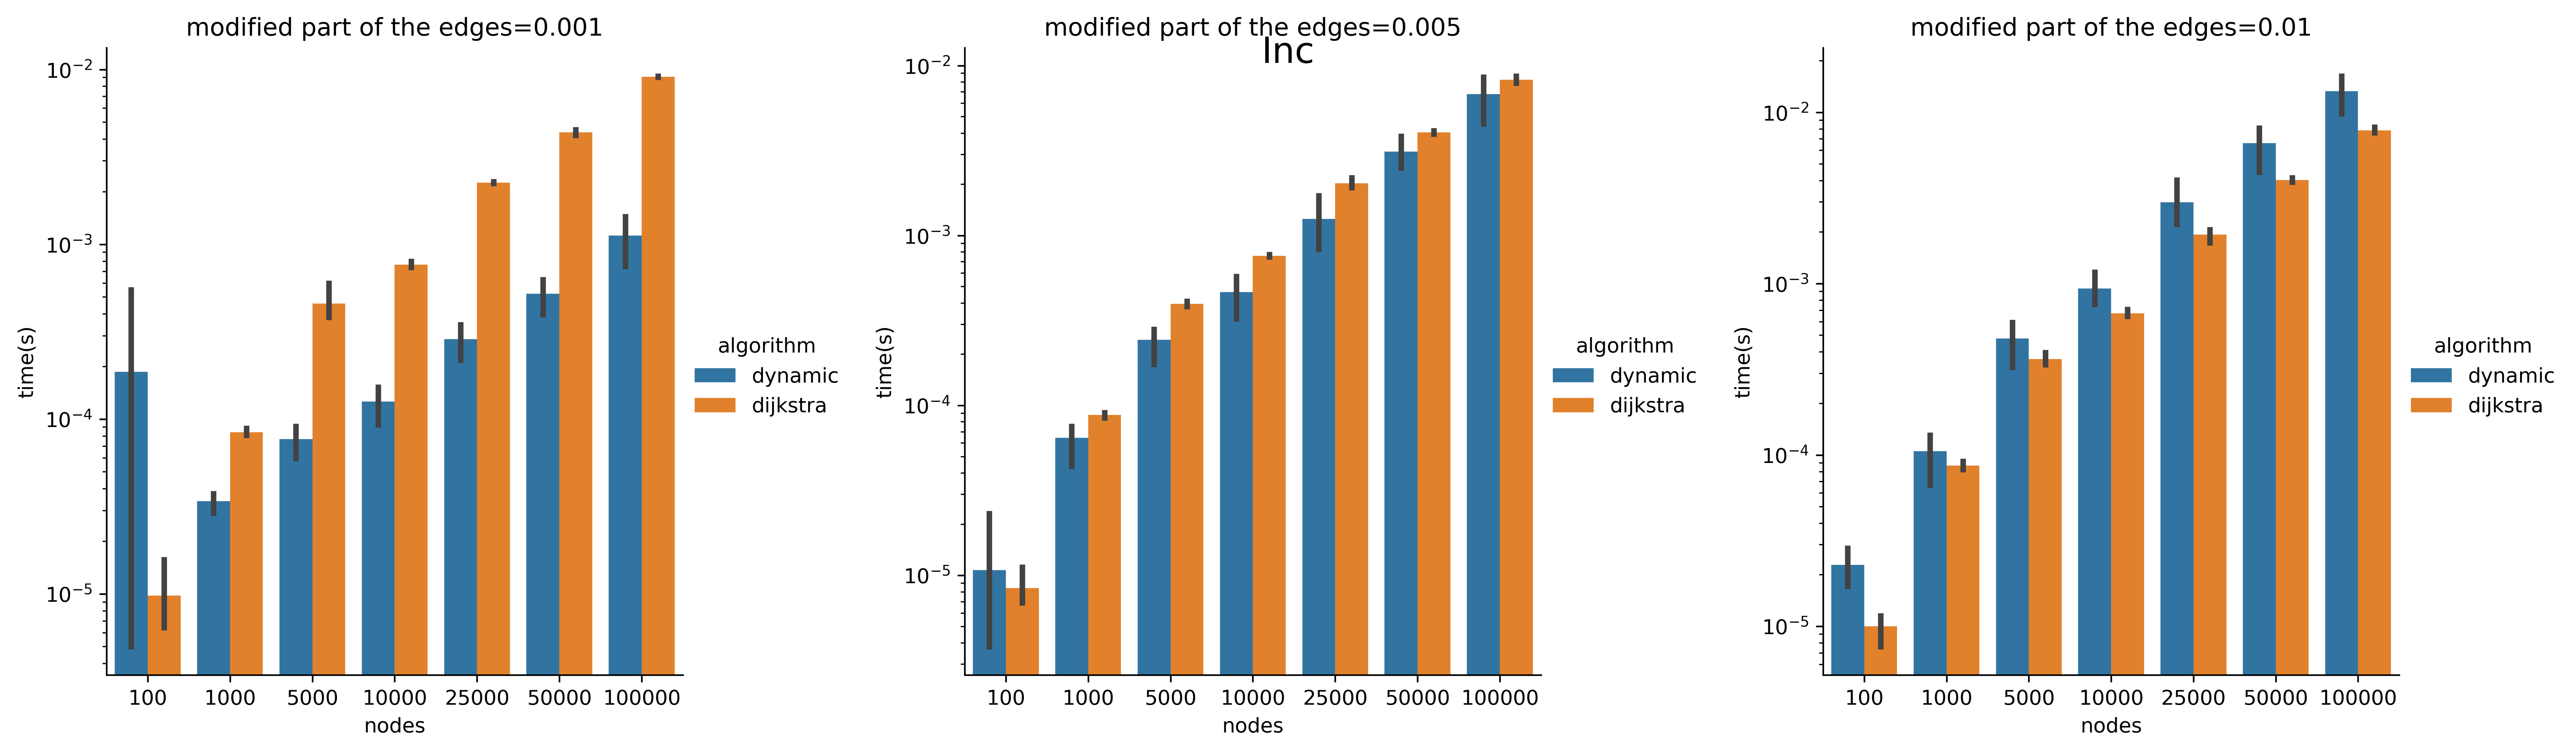

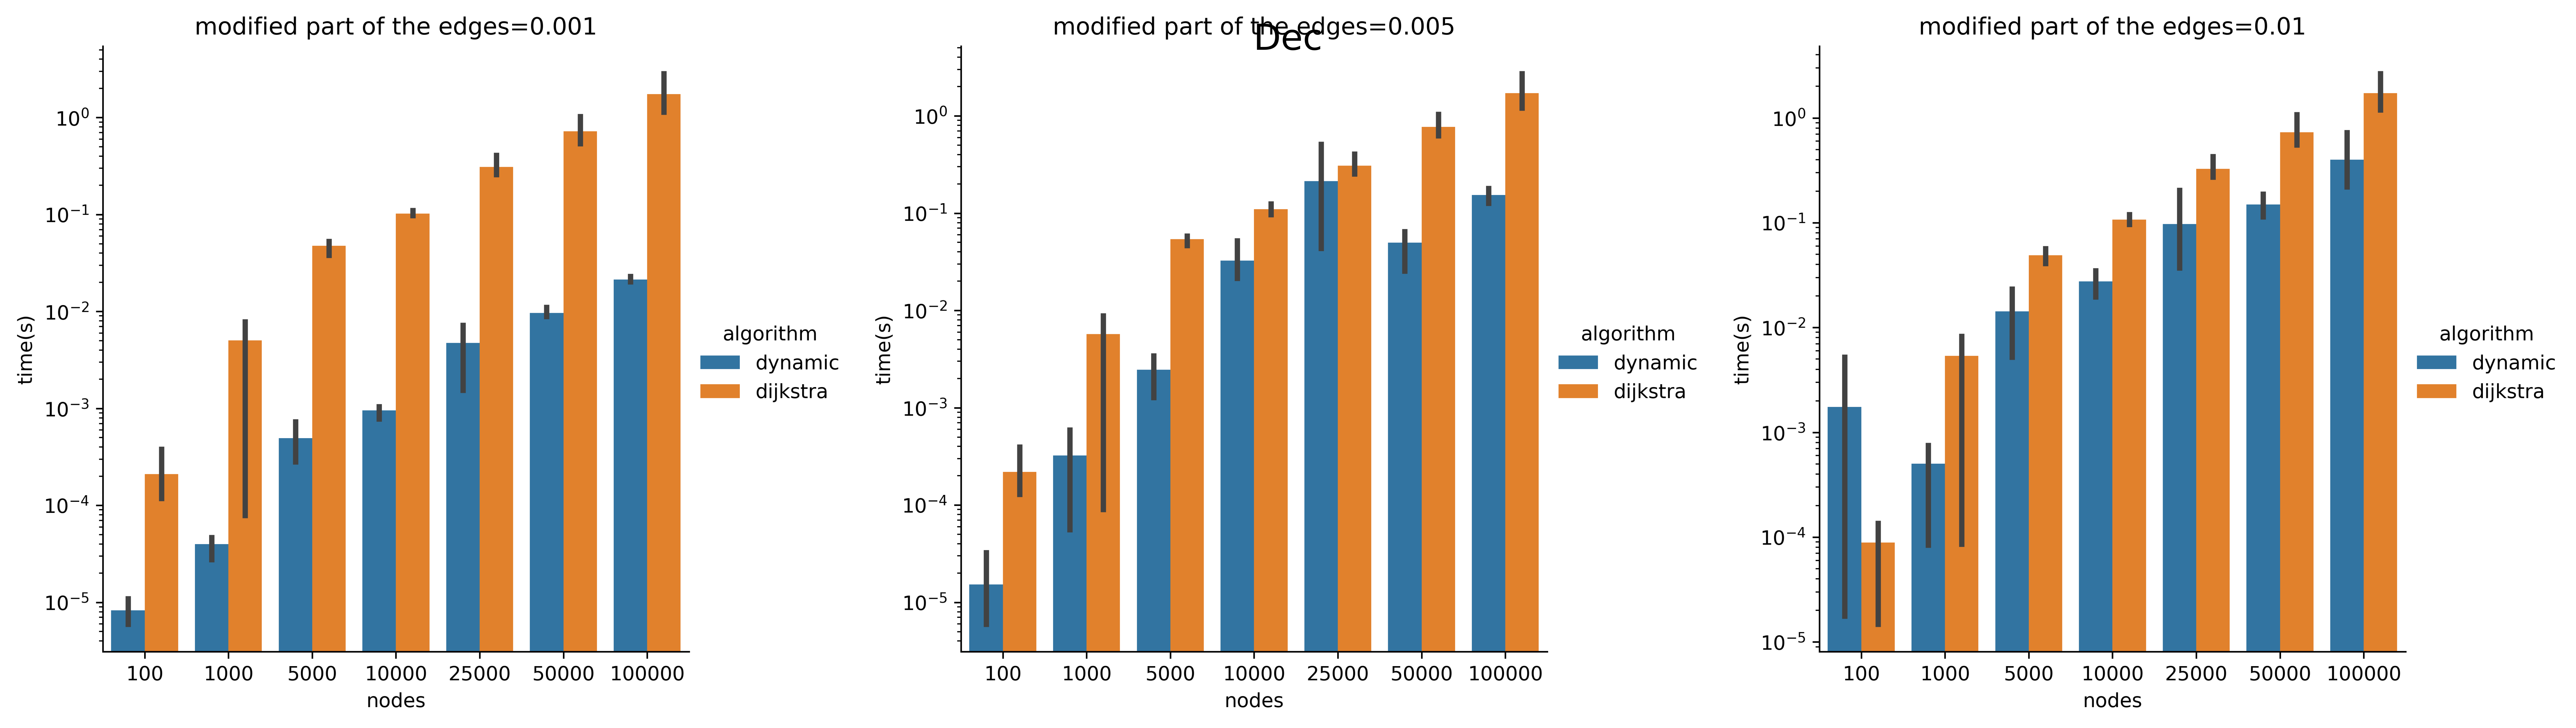

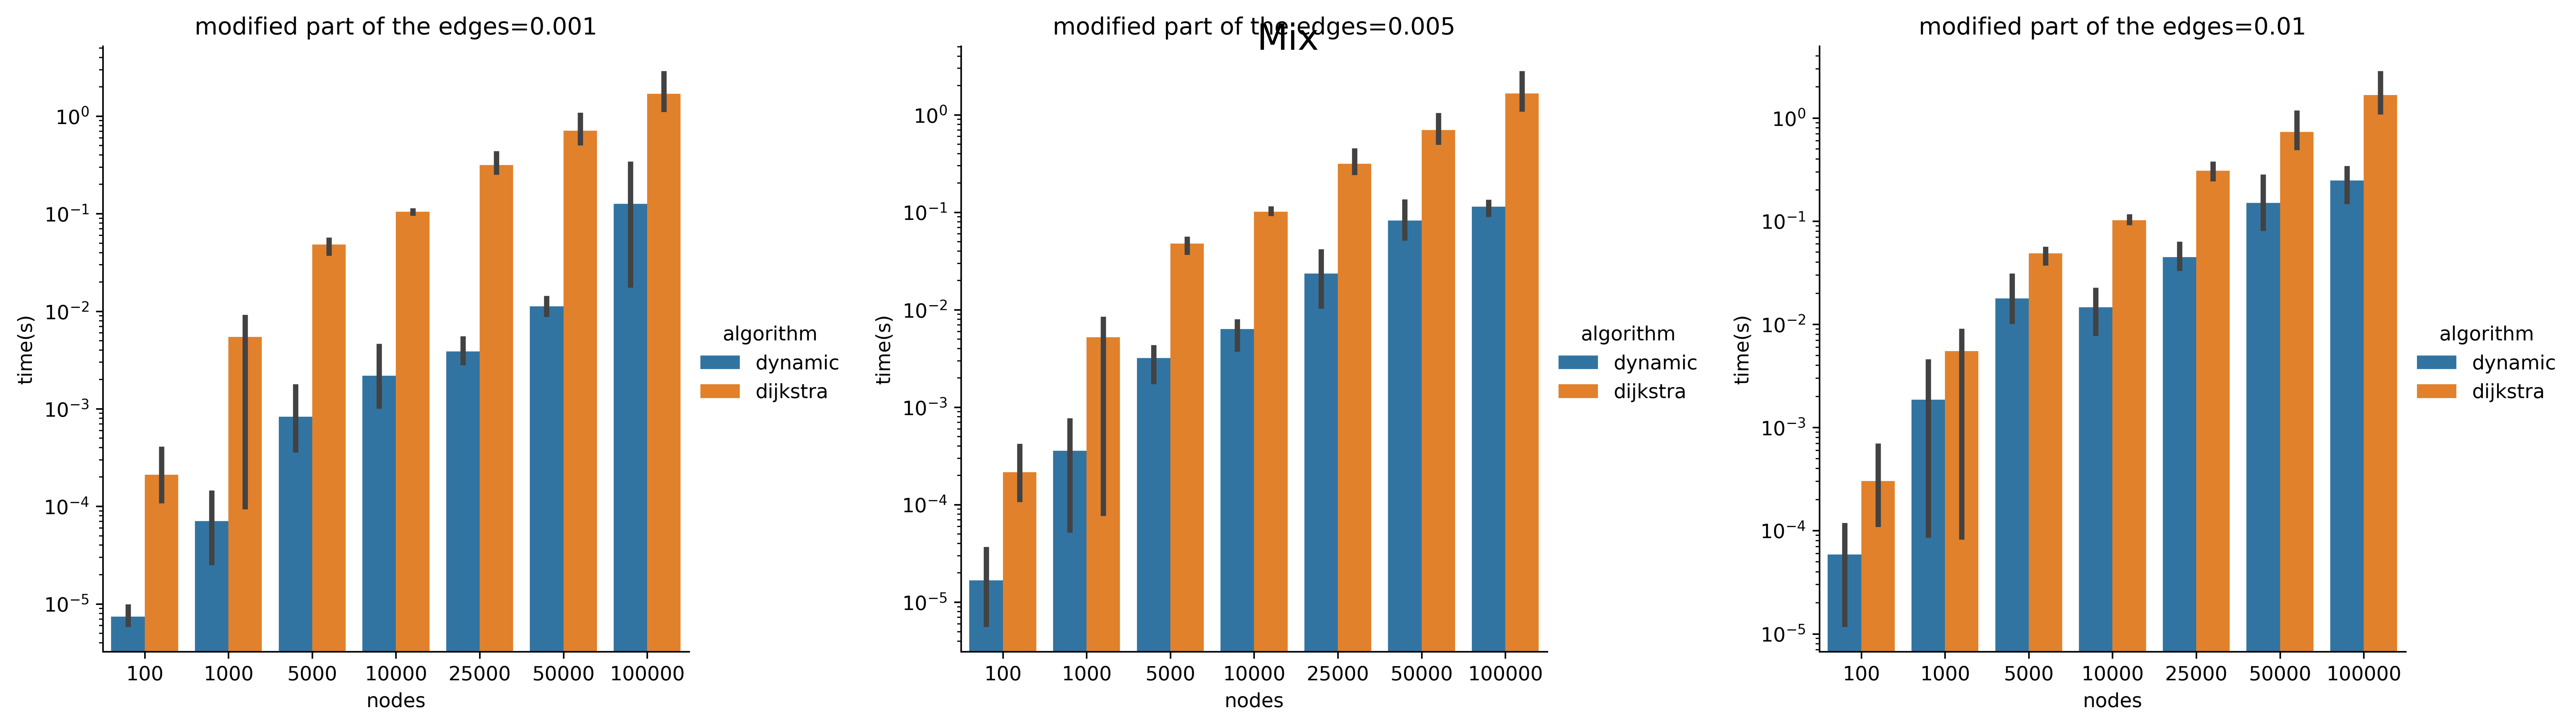

In [15]:
for mod in [
    'Inc', 
    'Dec', 
    'Mix'
]:
    plots = []
    for p in [0.001, 0.005, 0.01]:
        filtered_df = df[
            np.logical_and(df['mod'] == mod, df['modified_edges_part'] == p)
        ]
        plot = sns.catplot(
            data=filtered_df, 
            x="nodes",
            y="time(s)",
            hue="algorithm",
            kind='bar', 
        )
        plt.title(f"modified part of the edges={p}")
        plt.yscale("log")
        plots.append(to_image(plot))
        plt.close()
    
    fig, axs = plt.subplots(ncols=3, figsize=(100, 50))
    for ax, plot in zip(axs, plots):
        ax.imshow(plot)
        ax.axis("off")
    fig.set_tight_layout(True)
    fig.suptitle(f"{mod}", y=0.75, size=100)

### Вывод дополнительный:
Динамический алгоритм на немалых графах имеет преимущество перед статическим, при малой доле (< 1%) изменямых ребер, поэтому, при работе с немалыми графами и условии изменения малой доли ребер, имеет смысл выбрать динамический алгоритм. 
Если изменения не подразумевают добавления новых ребер, то 1% включительно.
